# **Task 1 - Load Data**

In [ ]:
!pip install datasets
!pip install accelerate -U

from datasets import load_dataset

!pip install transformers torch
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 5.4 MB/s eta 0:00:00


In [ ]:
dataset = load_dataset("dair-ai/emotion")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize(batch):
  return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=65)

dataset_encodings = dataset.map(tokenize, batched=True)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
emotion_labels = ['joy', 'anger', 'love', 'sadness', 'fear', 'surprise']
test_labels = [example['label'] for example in dataset_encodings["test"]]
predicted_emotions_test = [emotion_labels[id] for id in test_labels]

validation_labels = [example['label'] for example in dataset_encodings["validation"]]
predicted_emotions_validation = [emotion_labels[id] for id in validation_labels]

train_labels = [example['label'] for example in dataset_encodings["train"]]
predicted_emotions_train = [emotion_labels[id] for id in train_labels]

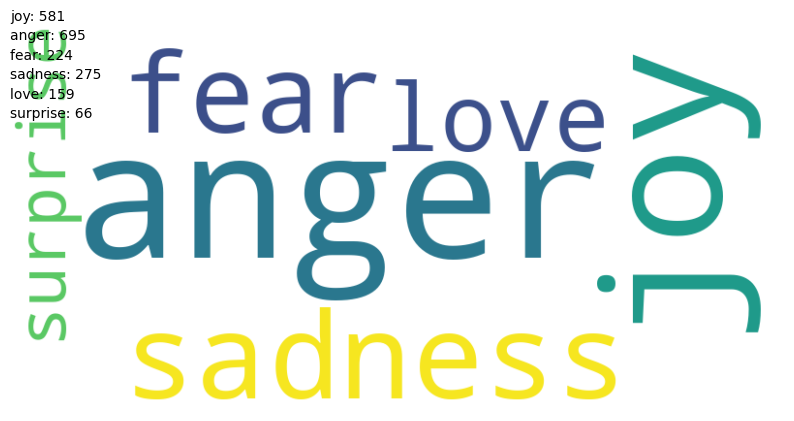

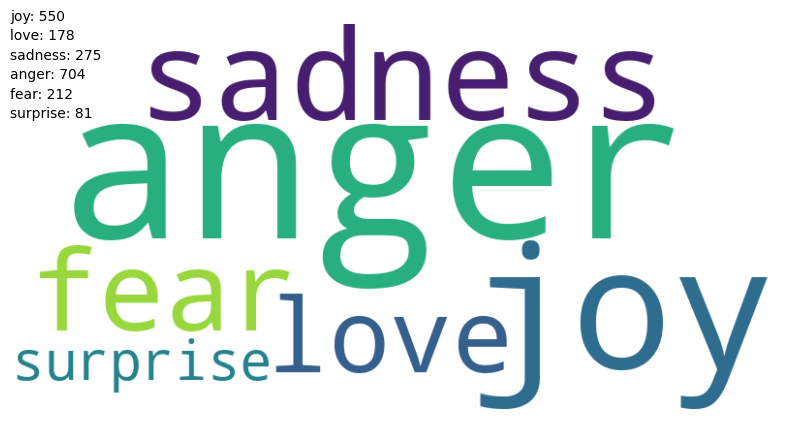

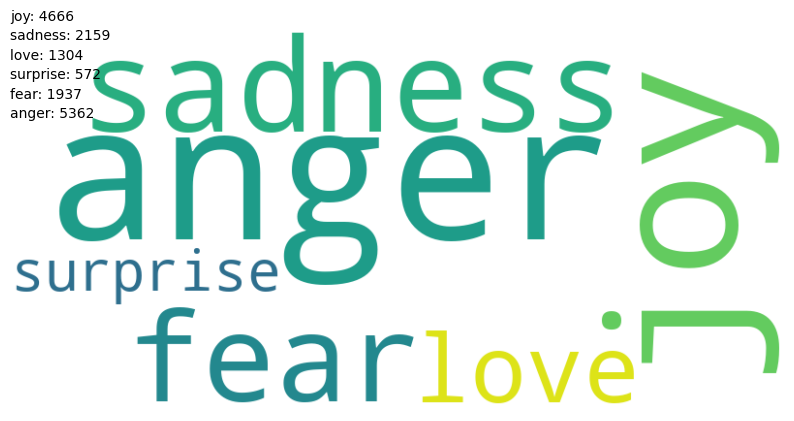

In [ ]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def wordCloud(data):
  word_freq = dict(Counter(data))

  wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

  plt.figure(figsize=(10, 8))
  plt.imshow(wordcloud, interpolation='bilinear')

  plt.axis('off')
  i = 0
  for word, freq in word_freq.items():
      plt.text(0, i, f"{word}: {freq}", horizontalalignment='left', verticalalignment='bottom')
      i += 20
  plt.show()

wordCloud(predicted_emotions_test)
wordCloud(predicted_emotions_validation)
wordCloud(predicted_emotions_train)

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Training BERT model

In [ ]:
training_args = TrainingArguments("test_trainer", evaluation_strategy="epoch")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_encodings["train"],
    eval_dataset=dataset_encodings["validation"]
)
trainer.train()


Epoch,Training Loss,Validation Loss
1,0.246400,0.202934
2,0.147100,0.196527
3,0.105400,0.226526


TrainOutput(global_step=6000, training_loss=0.2310487575531006, metrics={'train_runtime': 863.2011, 'train_samples_per_second': 55.607, 'train_steps_per_second': 6.951, 'total_flos': 1603390576320000.0, 'train_loss': 0.2310487575531006, 'epoch': 3.0})

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: Tesla T4


In [ ]:
#Testing with individual sentences
sentence = "This assignment is hard"
inputs = tokenizer(sentence, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}
outputs = model(**inputs)
predictions = torch.argmax(outputs.logits, dim=-1)
print(predictions)

Using GPU: Tesla T4
tensor([3], device='cuda:0')


In [ ]:
def predict_emotions(test_data, model, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for item in test_data:
            inputs = tokenizer(item['text'], return_tensors="pt", padding=True, truncation=True, max_length=65)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            outputs = model(**inputs)
            logits = outputs.logits
            predicted_class_id = torch.argmax(logits, dim=-1).item()
            predictions.append(predicted_class_id)

    return predictions

In [ ]:
# Perform predictions
test_predictions = predict_emotions(dataset_encodings["test"], model, device)

In [ ]:
emotion_labels = ['joy', 'anger', 'love', 'sadness', 'fear', 'surprise']
true_labels = [example['label'] for example in dataset_encodings["test"]]
predicted_emotions = [emotion_labels[id] for id in test_predictions]

print(true_labels)
print(test_predictions)
print(predicted_emotions)

[0, 0, 0, 1, 0, 4, 3, 1, 1, 3, 4, 0, 4, 1, 2, 0, 1, 0, 3, 1, 0, 1, 1, 0, 0, 4, 3, 0, 4, 3, 4, 3, 0, 3, 0, 1, 1, 0, 1, 1, 3, 0, 1, 0, 1, 3, 1, 1, 4, 4, 0, 4, 1, 0, 1, 0, 0, 1, 0, 3, 0, 0, 1, 1, 0, 5, 0, 3, 4, 5, 1, 2, 5, 1, 2, 3, 1, 0, 1, 2, 1, 3, 0, 1, 0, 0, 1, 1, 1, 0, 1, 4, 3, 4, 3, 3, 2, 0, 3, 0, 0, 0, 0, 4, 3, 3, 1, 1, 4, 0, 1, 2, 4, 1, 0, 1, 1, 4, 0, 1, 0, 1, 0, 3, 0, 2, 0, 4, 0, 0, 1, 2, 0, 3, 3, 1, 4, 3, 0, 1, 1, 0, 4, 1, 1, 0, 1, 4, 4, 2, 0, 2, 5, 0, 1, 0, 1, 1, 3, 0, 3, 3, 1, 4, 4, 1, 2, 2, 2, 0, 2, 3, 1, 1, 0, 3, 1, 1, 0, 0, 4, 1, 0, 2, 4, 0, 1, 1, 4, 3, 1, 0, 1, 3, 0, 0, 4, 4, 1, 1, 1, 2, 2, 1, 1, 1, 2, 4, 4, 1, 3, 0, 1, 4, 1, 0, 3, 0, 3, 3, 1, 4, 5, 1, 1, 1, 3, 1, 2, 4, 0, 0, 1, 1, 4, 1, 0, 1, 0, 1, 0, 2, 4, 1, 0, 0, 0, 3, 1, 5, 0, 0, 0, 3, 2, 0, 1, 1, 0, 3, 3, 3, 1, 3, 3, 2, 1, 1, 3, 0, 3, 3, 4, 0, 3, 0, 1, 4, 3, 0, 1, 0, 0, 1, 1, 1, 2, 0, 1, 1, 5, 4, 2, 0, 2, 4, 3, 0, 0, 3, 1, 3, 2, 2, 1, 4, 3, 2, 4, 4, 1, 0, 4, 1, 0, 3, 2, 5, 3, 4, 0, 0, 0, 1, 0, 0, 2, 3, 0, 0, 4, 0, 0, 

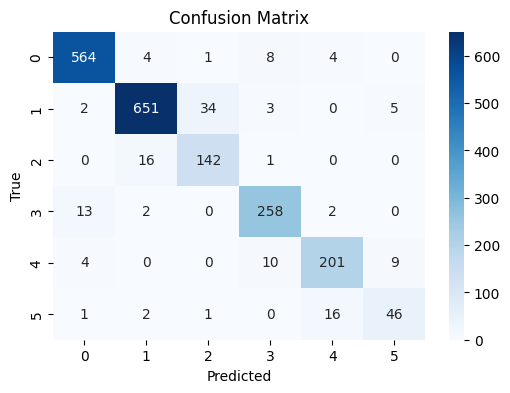

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
data = {'True Values': true_labels, 'Predicted Values': test_predictions}
results = pd.DataFrame(data)

confusion_matrix = pd.crosstab(results['True Values'], results['Predicted Values'], rownames=['True'], colnames=['Predicted'])

plt.figure(figsize=(6, 4))
heatmap = sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
accuracy_percentage = calculate_accuracy(true_labels, test_predictions)
print(f"Model Accuracy: {accuracy_percentage:.2f}%")

Model Accuracy: 93.25%


In [ ]:
def calculate_accuracy(true_labels, predicted_labels):
    correct_predictions = sum([true == pred for true, pred in zip(true_labels, predicted_labels)])
    total_predictions = len(predicted_labels)
    accuracy = correct_predictions / total_predictions
    return accuracy * 100

In [ ]:
grid = {
    'num_train_epochs': [2, 3, 4],
    'per_device_train_batch_size': [16, 32],
    'per_device_eval_batch_size': [16, 32],
    'warmup_steps': [0, 500],
    'weight_decay': [0.0, 0.01]
}

# Function to perform grid search
def param_search(model, train_dataset, eval_dataset, test_dataset, num_train_epochs=2, train_batch_size=16, eval_batch_size=16, warmup_steps=0, weight_decay=0, logging_steps=10):
    print("num_train_epochs: ", num_train_epochs)
    print("train_batch_size: ", train_batch_size)
    print("eval_batch_size: ", eval_batch_size)
    print("warmup_steps: ", warmup_steps)
    print("weight_decay: ", weight_decay)
    print("logging_steps: ", logging_steps)
    # Define training arguments
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=train_batch_size,
        per_device_eval_batch_size=eval_batch_size,
        warmup_steps=warmup_steps,
        weight_decay=weight_decay,
        logging_steps=logging_steps,
        evaluation_strategy="epoch"
    )

    # Initialize the Trainer
    trainer_fine_tuning = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset
    )

    # Train the model
    trainer_fine_tuning.train()

    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using GPU:", torch.cuda.get_device_name(0))
    else:
        device = torch.device("cpu")
        print("Using CPU")

    #predictions
    test_predictions = predict_emotions(test_dataset, model, device)
    true_labels = [example['label'] for example in test_dataset]
    accuracy_percentage = calculate_accuracy(true_labels, test_predictions)
    print(f"Model Accuracy: {accuracy_percentage:.2f}%")

### # of Epoch Comparison

In [ ]:
param_search(model, dataset_encodings["train"], dataset_encodings["validation"], dataset_encodings["test"], num_train_epochs=2)
param_search(model, dataset_encodings["train"], dataset_encodings["validation"], dataset_encodings["test"], num_train_epochs=3)
param_search(model, dataset_encodings["train"], dataset_encodings["validation"], dataset_encodings["test"], num_train_epochs=4)

num_train_epochs:  2
train_batch_size:  16
eval_batch_size:  16
warmup_steps:  0
weight_decay:  0
logging_steps:  10


Epoch,Training Loss,Validation Loss
1,0.079100,0.192629
2,0.078300,0.220653


Using GPU: Tesla T4
Model Accuracy: 93.10%
num_train_epochs:  3
train_batch_size:  16
eval_batch_size:  16
warmup_steps:  0
weight_decay:  0
logging_steps:  10


Epoch,Training Loss,Validation Loss
1,0.133500,0.299268
2,0.056200,0.331350
3,0.057800,0.335960


Using GPU: Tesla T4
Model Accuracy: 92.95%
num_train_epochs:  4
train_batch_size:  16
eval_batch_size:  16
warmup_steps:  0
weight_decay:  0
logging_steps:  10


Epoch,Training Loss,Validation Loss
1,0.030900,0.430058
2,0.000500,0.396258
3,0.186900,0.373220
4,0.000200,0.362009


Using GPU: Tesla T4
Model Accuracy: 92.75%


### Train Batch Size and Eval Batch Size Comparison

In [ ]:
param_search(model, dataset_encodings["train"], dataset_encodings["validation"], dataset_encodings["test"], num_train_epochs=3, train_batch_size=16, eval_batch_size=16)
param_search(model, dataset_encodings["train"], dataset_encodings["validation"], dataset_encodings["test"], num_train_epochs=3, train_batch_size=32, eval_batch_size=32)

num_train_epochs:  3
train_batch_size:  16
eval_batch_size:  16
warmup_steps:  0
weight_decay:  0
logging_steps:  10


Epoch,Training Loss,Validation Loss
1,0.000200,0.581614
2,0.000200,0.512638
3,0.005400,0.537151


Using GPU: Tesla T4
Model Accuracy: 92.95%
num_train_epochs:  3
train_batch_size:  32
eval_batch_size:  32
warmup_steps:  0
weight_decay:  0
logging_steps:  10


Epoch,Training Loss,Validation Loss
1,0.001300,0.504601
2,0.027600,0.517453
3,0.015300,0.467497


Using GPU: Tesla T4
Model Accuracy: 92.90%


### Warmup Steps Comparison

In [ ]:
param_search(model, dataset_encodings["train"], dataset_encodings["validation"], dataset_encodings["test"], num_train_epochs=3, train_batch_size=32, eval_batch_size=32, warmup_steps=0)
param_search(model, dataset_encodings["train"], dataset_encodings["validation"], dataset_encodings["test"], num_train_epochs=3, train_batch_size=32, eval_batch_size=32, warmup_steps=500)

num_train_epochs:  3
train_batch_size:  32
eval_batch_size:  32
warmup_steps:  0
weight_decay:  0
logging_steps:  10


Epoch,Training Loss,Validation Loss
1,0.034800,0.508482
2,0.011500,0.485761
3,0.005200,0.483882


Using GPU: Tesla T4
Model Accuracy: 93.45%
num_train_epochs:  3
train_batch_size:  32
eval_batch_size:  32
warmup_steps:  500
weight_decay:  0
logging_steps:  10


Epoch,Training Loss,Validation Loss
1,0.095700,0.506805
2,0.000700,0.516890
3,0.037800,0.474042


Using GPU: Tesla T4
Model Accuracy: 93.15%


### Weight Decay Comparison

In [ ]:
param_search(model, dataset_encodings["train"], dataset_encodings["validation"], dataset_encodings["test"], num_train_epochs=3, train_batch_size=32, eval_batch_size=32, warmup_steps=0, weight_decay=0.0)
param_search(model, dataset_encodings["train"], dataset_encodings["validation"], dataset_encodings["test"], num_train_epochs=3, train_batch_size=32, eval_batch_size=32, warmup_steps=0, weight_decay=0.01)


num_train_epochs:  3
train_batch_size:  32
eval_batch_size:  32
warmup_steps:  0
weight_decay:  0.0
logging_steps:  10


Epoch,Training Loss,Validation Loss
1,0.080500,0.643066
2,0.000200,0.499161
3,0.030700,0.472655


Using GPU: Tesla T4
Model Accuracy: 92.95%
num_train_epochs:  3
train_batch_size:  32
eval_batch_size:  32
warmup_steps:  0
weight_decay:  0.01
logging_steps:  10


Epoch,Training Loss,Validation Loss
1,0.000100,0.556515
2,0.013000,0.506616
3,0.009200,0.514989


Using GPU: Tesla T4
Model Accuracy: 92.70%


In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=0,
    weight_decay=0.0,
    logging_steps=10,
    evaluation_strategy="epoch"
)

# Initialize the Trainer
trainer_fine_tuning = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_encodings["train"],
    eval_dataset=dataset_encodings["validation"]
)

# Train the model
trainer_fine_tuning.train()

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

#predictions
test_predictions = predict_emotions(dataset_encodings["test"], model, device)

Epoch,Training Loss,Validation Loss
1,0.059100,0.198993
2,0.040100,0.234265
3,0.027100,0.279716


Using GPU: Tesla T4


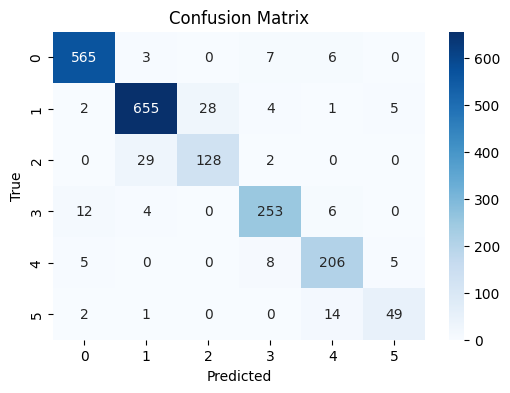

In [ ]:
data = {'True Values': true_labels, 'Predicted Values': test_predictions}
results = pd.DataFrame(data)

confusion_matrix = pd.crosstab(results['True Values'], results['Predicted Values'], rownames=['True'], colnames=['Predicted'])

plt.figure(figsize=(6, 4))
heatmap = sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()